<a href="https://colab.research.google.com/github/Vincenzo-Miracula/MasterSDS/blob/main/mastodon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

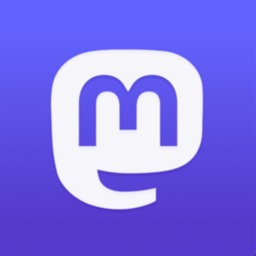

# Analisi del Codice per Estrazione di Toots da Mastodon

### 1. Installazione delle Librerie
Il codice inizia con l'installazione della libreria `Mastodon.py` utilizzata per interagire con l'API di Mastodon.


### 2. Importazione delle Librerie
Le seguenti librerie vengono importate per essere utilizzate nel codice:
- **Mastodon**: La libreria principale per interagire con l'API di Mastodon.
- **time**: Utilizzata per gestire il tempo, se necessario (anche se non utilizzata direttamente nel codice).
- **pandas**: Per organizzare i dati in un DataFrame.
- **re**: Per lavorare con espressioni regolari (anche se non utilizzata nel codice).
- **configparser**: Per leggere il file di configurazione contenente il token di accesso a Mastodon.
- **BeautifulSoup (bs4)**: Utilizzata per rimuovere i tag HTML dai testi dei toots.

### 3. Lettura del File di Configurazione
Il codice carica il file di configurazione `config.ini` utilizzando `configparser` per leggere il **token di accesso** necessario per interagire con l'API di Mastodon. Viene anche definita la base URL dell'API di Mastodon (`https://mastodon.social`).

### 4. Autenticazione e Connessione all'API
Viene creato un oggetto `Mastodon` utilizzando il token di accesso e l'API base URL specificata. Questo oggetto consente di fare richieste all'API di Mastodon.

### 5. Impostazione dell'Hashtag e delle Variabili
Viene definito l'hashtag da cui estrarre i "toots" (post di Mastodon) e il limite massimo di "toots" da raccogliere (1000 in questo caso). Viene anche creata una lista vuota `all_toots` per memorizzare i risultati.

- **hashtag**: L'hashtag di interesse per la raccolta dei "toots".
- **limit**: Il numero massimo di "toots" da estrarre.
- **all_toots**: Lista che contiene tutti i "toots" estratti.

### 6. Estrazione dei Toots
Il codice entra in un ciclo `while` per raccogliere i "toots" associati all'hashtag. La funzione `m.timeline_hashtag()` recupera i "toots" più recenti associati all'hashtag specificato, con un limite di risultati definito.

- **max_id**: L'ID dell'ultimo "toot" estratto viene usato come parametro per la paginazione, in modo che la richiesta successiva prenda i "toots" precedenti.
- **last_id**: Contiene l'ID dell'ultimo "toot" estratto. Ogni volta che nuovi "toots" vengono aggiunti, l'ID dell'ultimo "toot" viene aggiornato.

Il ciclo continua finché non vengono estratti il numero massimo di "toots" definito o finché non ci sono più risultati disponibili.

### 7. Organizzazione dei Dati
I dati estratti dai "toots" vengono organizzati in un formato strutturato (DataFrame) utilizzando la libreria **pandas**. Ogni "toot" è rappresentato come una riga nel DataFrame con le seguenti colonne:
- **Date**: La data di creazione del "toot".
- **ID**: L'ID dell'account che ha pubblicato il "toot".
- **User**: Il nome dell'utente che ha pubblicato il "toot".
- **Text**: Il contenuto del "toot".
- **Lang**: La lingua del "toot".
- **Rep**: L'ID dell'account a cui il "toot" è una risposta (se presente).

### 8. Pulizia del Testo
Una funzione **estrai_contenuto()** utilizza BeautifulSoup per rimuovere i tag HTML dal testo del "toot", lasciando solo il contenuto testuale. Questa funzione viene applicata alla colonna **Text** per creare una nuova colonna **clean_text** contenente il testo pulito.

### 9. Visualizzazione del DataFrame
Il DataFrame finale contiene i dati relativi ai "toots", inclusi i testi puliti (senza tag HTML), e può essere utilizzato per ulteriori analisi.


In [ ]:
!pip install Mastodon.py

In [3]:
from mastodon import Mastodon
import time
import pandas as pd
import re
import configparser
from bs4 import BeautifulSoup as bs

In [4]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [6]:
m = Mastodon(access_token=config['mastodon']['token'], api_base_url="https://mastodon.social")

hashtag = ''  # Sostituisci con l'hashtag desiderato
limit = 1000

In [19]:
all_toots = []

last_id = None
while len(all_toots) < limit:
    results = m.timeline_hashtag(hashtag, limit=limit - len(all_toots), max_id=last_id)
    if not results:
        break
    last_id = results[-1].id - 1
    all_toots.extend(results)

columns = ['Date', 'ID', 'User', 'Text', 'Lang', 'Rep']
data = []

for status in all_toots:
    fecha = status['created_at']
    userID = status['account']['id']
    username = status['account']['display_name']
    text = status['content']
    lang = status['language']
    rep = status['in_reply_to_account_id']

    data.append({
        'Date': fecha,
        'ID': userID,
        'User': username,
        'Text': text,
        'Lang': lang,
        'Rep': rep
    })

dfToot = pd.DataFrame(data, columns=columns)

In [21]:
def estrai_contenuto(testo):
        soup = bs(testo, 'html.parser')
        return soup.text

dfToot['clean_text'] = dfToot['Text'].astype(str).apply(estrai_contenuto)

In [ ]:
dfToot